run jupyter notebook, start that server and paste the url and select the kernel

In [5]:
!which python

/Users/dedeepyaavancha/Desktop/Projects-Nov25/Neural-Net/v1/venv/bin/python


In [6]:
import os
import getpass

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("TAVILY_API_KEY")

In [7]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tavily_tool = TavilySearch(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"



In [9]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

In [10]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o")

search_agent = create_react_agent(llm, tools=[tavily_tool])


def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

/var/folders/c3/299z_6451mlglnxycxmfkc1c0000gn/T/ipykernel_66639/1763639369.py:7: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  search_agent = create_react_agent(llm, tools=[tavily_tool])
/var/folders/c3/299z_6451mlglnxycxmfkc1c0000gn/T/ipykernel_66639/1763639369.py:23: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


In [11]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

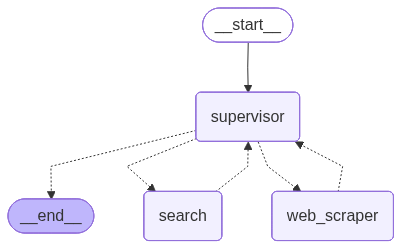

In [12]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [13]:
for s in research_graph.stream(
    {"messages": [("user", "What is the timeline for IKDD Uplink 2026 Internship?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='The IKDD Uplink 2026 Internship timeline is as follows:\n\n- **Application Deadline:** The application closes on 31st October.\n- **Internship Duration:** The internship runs from May 1 to July 31, 2026.\n- **Stipend:** A stipend of 50,000 INR will be provided for the three-month period upon successful completion of the internship.\n\nFor more details, you can visit the [official UPLINK 2026 page](https://ikdd.acm.org/uplink.php).', additional_kwargs={}, response_metadata={}, name='search', id='e502f234-42e3-4b97-9c25-54888bd69ef4')]}}
---
{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='The timeline for the IKDD Uplink 2026 Internship is as follows:\n\n- **Application Deadline:** Closes on 31st October.\n- **Internship Duration:** May 1 to July 31, 2026.\n- **Stipend:** 50,000 INR for the three-month period, provided upon successful completion.\n\nYou can find mor

In [15]:
from langchain.agents import create_agent

llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    system_prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_agent(
    llm,
    tools=[create_outline, read_document],
    system_prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )





doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker"]
)

In [16]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

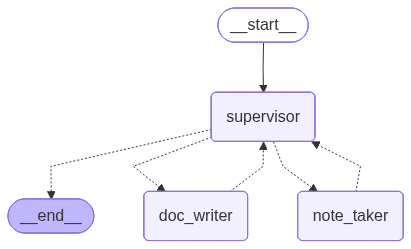

In [17]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [18]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='The outline for the poem about cats has been created and saved as "poem_outline.txt".', additional_kwargs={}, response_metadata={}, name='note_taker', id='a9b0d000-9023-4130-8be2-940a07da9aa6')]}}
---
{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='The poem about cats has been written and saved as "cat_poem.txt".', additional_kwargs={}, response_metadata={}, name='doc_writer', id='a67fed6a-6d5c-4114-a4da-2814e137d538')]}}
---
{'supervisor': {'next': '__end__'}}
---


In [19]:
from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [20]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

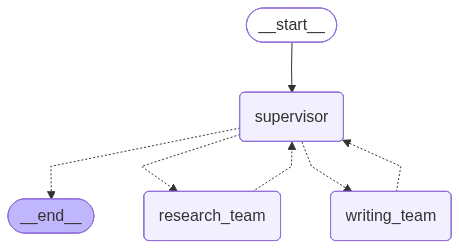

In [21]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [22]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research neuromorphic computing and write an introduction for it in less than 4 bullets.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content='1. **Brain-Inspired Approach**: Neuromorphic computing technology mimics the structure and functionality of the human brain, employing artificial neurons and synapses to carry out computations, focusing on tasks like perception, pattern recognition, and decision-making.\n\n2. **Interdisciplinary Field**: It involves a cross-disciplinary integration of biology, physics, mathematics, computer science, and electronic engineering to recreate the brain’s architecture and computational approaches.\n\n3. **Efficiency and Adaptability**: Known for energy efficiency and adaptability, neuromorphic systems excel in real-time learning and can continuously adapt to new stimuli, suiting dynamic environments and applications.\n\n4. **Advanced Applications**: These systems enhance computational capacities for AI, improving efficiency in areas such as machine learning, sensory processing, natural languag